### Loading libraries

In [1]:
library(vegan)
library(phyloseq)
library(ranacapa)
library(ape)
library(ggplot2)
library(ggpubr)
library(DESeq2)
library(EnhancedVolcano)
library(reshape2)
library(zCompositions)
library(dplyr)
library(writexl)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘ggpubr’


The following object is masked from ‘package:ape’:

    rotate


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following ob

In [2]:
# creating directories
dir.create(file.path('../../results/figures'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'supplementary_figure5'), showWarnings = FALSE)

## All samples

### Load data

In [3]:
# load genus level agglomerated data
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')

# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))

# tax_data['names'] <- paste(tax_data[, 'Family'], tax_data[, 'Genus'], sep=';')
tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]

### Deseq2

In [5]:
# In this cell we subsetthe otu_table to include only samples 
# from participants who have been sampled at the both time points
otu_data <- data.frame(otu_table(ps))
metadata <- data.frame(sample_data(ps))
# split metadata table into 2: 1 only for baseline samples, one for the follow-up
group_baseline <- metadata[metadata[['collection_timepoint']] == 'baseline', ]
group_followup <- metadata[metadata[['collection_timepoint']] == 'follow-up', ]
row.names(group_baseline) <- group_baseline[['host_subject_id']]
row.names(group_followup) <- group_followup[['host_subject_id']]
# select participants from the baseline metadata table who are also included in the follow-up table
# p.s. meaning, such participans were samppled at the follow-up
group_baseline <- group_baseline[row.names(group_followup), ]
row.names(group_baseline) <- group_baseline[['sample_alias']]
row.names(group_followup) <- group_followup[['sample_alias']]
# bind baseline metadata table with selected rows and the follow-up table
metadata_deseq2 <- rbind(group_baseline, group_followup)
# subsample otu_table: select only the samples, which are included in the bind metadata table
otu_data_deseq2 <- otu_data[row.names(metadata_deseq2), ]

In [6]:
# check that we do not have any unpaired samples left
# the result should be 0
sum(table(metadata_deseq2['host_subject_id']) != 2)

[1] 0

In [7]:
# check that samples are in correct order for the paired test
# the result should be 0
sum((metadata_deseq2[metadata_deseq2$collection_timepoint == 'baseline', 'host_subject_id'] ==
     metadata_deseq2[metadata_deseq2$collection_timepoint == 'follow-up', 'host_subject_id']) != TRUE)

[1] 0

In [8]:
# subset the phyloseq object with the preselected samples
ps <- prune_samples(row.names(metadata_deseq2), ps)
ps
sample_data(ps)['host_subject_id'] <- factor(sample_data(ps)[['host_subject_id']])
sample_data(ps)['collection_timepoint'] <- factor(sample_data(ps)[['collection_timepoint']], levels=c('follow-up', 'baseline'))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 397 taxa and 134 samples ]
sample_data() Sample Data:       [ 134 samples by 57 sample variables ]
tax_table()   Taxonomy Table:    [ 397 taxa by 7 taxonomic ranks ]

In [9]:
# convert a phyloseq object to a deseq2 object
dds <- phyloseq_to_deseq2(ps, ~ collection_timepoint+host_subject_id)
# perform a DESeq analysis
dds <- DESeq(dds)
dds_res <- data.frame(results(dds))
dds_res_summary <- dds_res
dds_res['lab'] <- row.names(dds_res)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R.

In [10]:
p_values_summary_table_1 <- cbind(data.frame(tax_table(ps))[row.names(dds_res_summary), 
                                      c('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus')], 
                        dds_res_summary)

### Deseq2 Plots

In [11]:
dds_res <- dds_res[!is.na(dds_res$padj), ]
dds_res$point_size <- 5
dds_res[dds_res$padj <= 0.05, 'point_size'] <- 8
dds_res[dds_res$padj <= 0.05, ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,lab,point_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
CAG-873,917.89043,-29.24648,6.321096,-4.626805,3.713496e-06,0.0005941594,CAG-873,8
Cerasicoccus,61.14843,-19.59143,4.123529,-4.751132,2.022814e-06,0.0005941594,Cerasicoccus,8


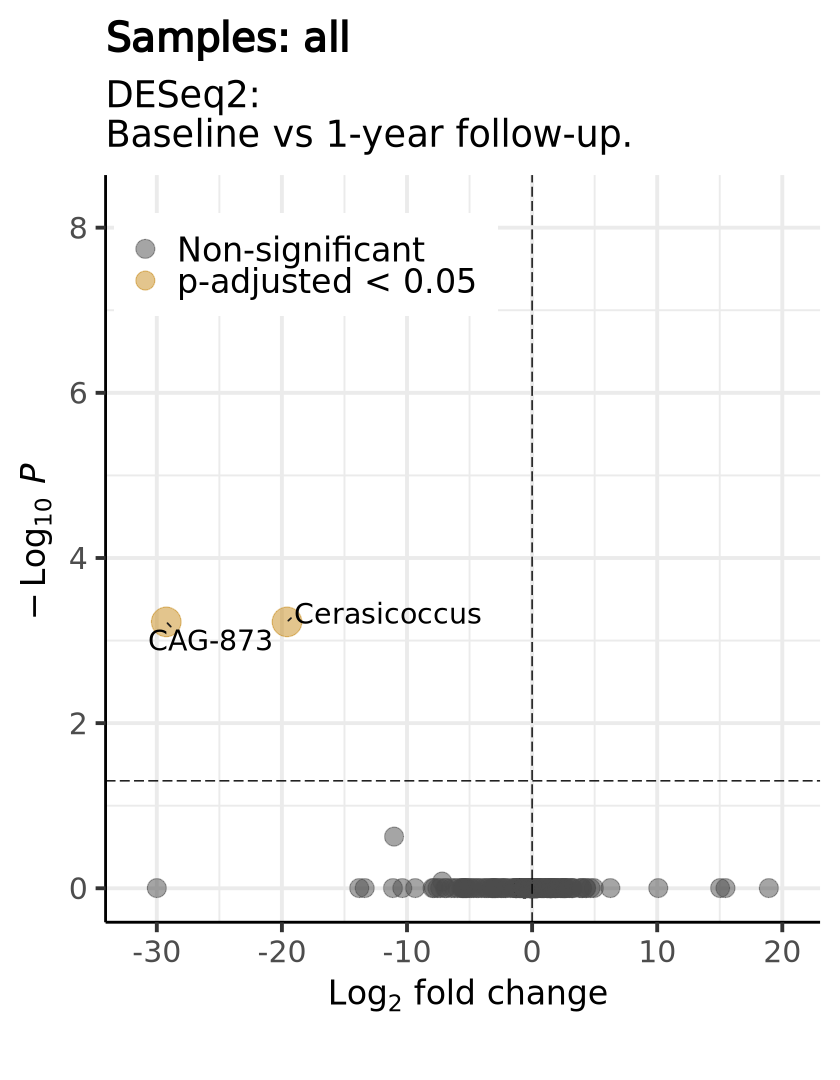

In [12]:
# volcano plot
width = 7
height = 9
options(repr.plot.width=width, repr.plot.height=height)

pCutoff <- 50e-3 # 0.05
FCcutoff <- 1

p <- EnhancedVolcano(dds_res,
                lab = dds_res[['lab']], 
    x = 'log2FoldChange',
    y = 'padj', 
    pCutoff = pCutoff,
    FCcutoff = 0,
    labSize = 6,
    legendPosition = c(0.28, 0.88),
    legendLabSize = 20, 
    legendLabels = c("", "Non-significant", "", "p-adjusted < 0.05"),
    pointSize=dds_res$point_size, 
    drawConnectors = TRUE, 
    lengthConnectors = unit(0.2, "npc"),
    arrowheads = FALSE,
    colAlpha=0.5,
    col = c("grey30", "grey30", "royalblue", "#c88c1c" ),
    title = bquote("Samples: all"),
    subtitle = "DESeq2:\nBaseline vs 1-year follow-up.",
    titleLabSize = 24,
    subtitleLabSize = 22,
    caption = "") +
    theme(axis.title=element_text(size=20))
print(p)

k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure5', 'DESeq2.volcano_plot.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)

#### Boxplots

In [13]:
# reload and re-prepare data as it was done baseline

ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')
# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))
tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]
ps_relative <- prune_samples(row.names(metadata_deseq2), ps)
# normalize abundances
ps_relative <- transform_sample_counts(ps_relative, function(x){x / sum(x)})
# eliminate taxa that are harnoured only by one sample
otu_data <- as.data.frame(otu_table(ps_relative))

In [14]:
# choose only significant taxa
otu_data_boxplot <- otu_data[, dds_res[dds_res$padj <= 0.05, ]$lab]
otu_data_boxplot$grouping <- factor(metadata_deseq2[row.names(otu_data_boxplot), 'collection_timepoint'],
                                    levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_deseq2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)

Using grouping, host_subject_id as id variables



In [15]:
# prepare p-values table for plotting
test_pvalues <- dds_res[dds_res$padj <= 0.05, ]
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"
test_pvalues$plabel <- format(test_pvalues$padj, fmt='e', digits=4)
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1

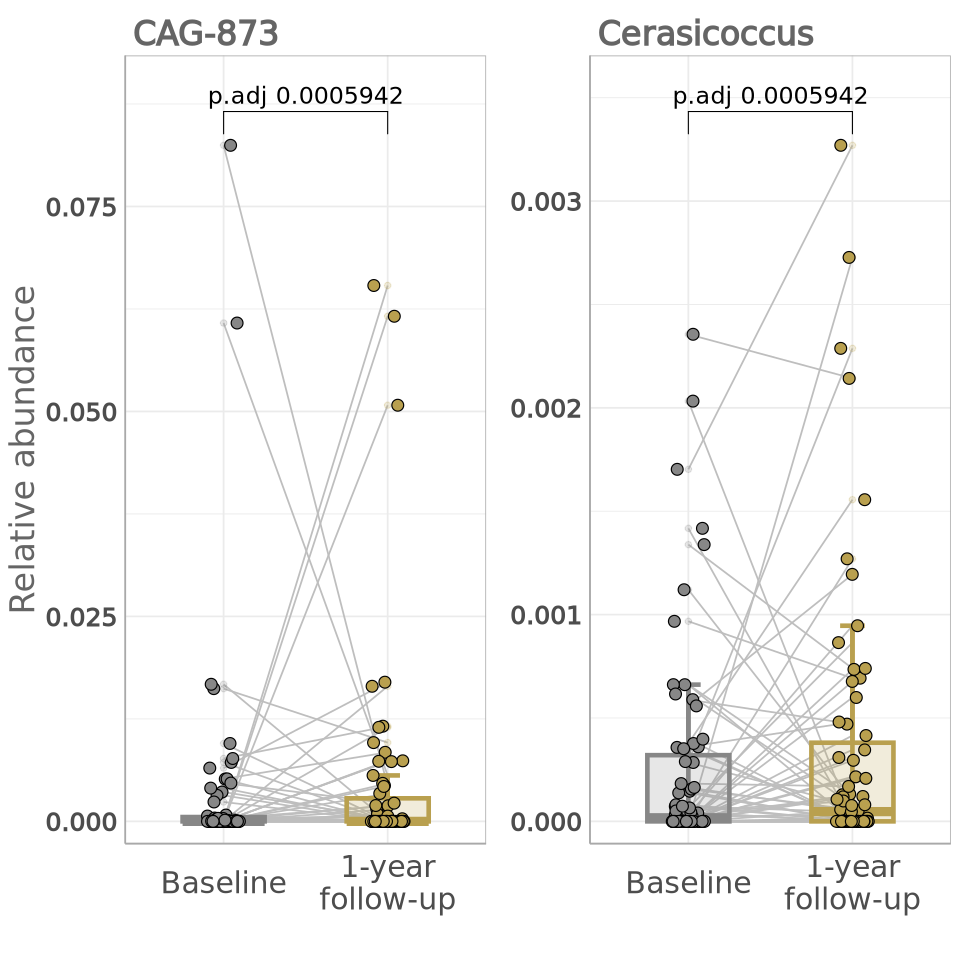

In [16]:
width = 8
height = 8
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
      geom_line(aes(x = grouping, y=value, group = host_subject_id), color = "gray", linewidth = 0.5,) +
      stat_boxplot(aes(x=grouping, y=value, color = grouping), 
                   geom = "errorbar", width = 0.15, lwd=1.3) +
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                   alpha=0.2, lwd=1.3, width=0.5) +
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping), 
                  size=3, width=0.1, shape=21, color='black')  + 
      stat_pvalue_manual(data=test_pvalues, label='p.adj {plabel}', label.size=5, tip.length=0.03) +
      facet_wrap(~variable, scales = "free_y", ncol=4) + 
      scale_fill_manual(values = c('#878787', '#b9a04f')) + ##92c1b7
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
      
      labs(x = "", y = "Relative abundance") +
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
      scale_y_continuous(expand = expansion(mult = 0.03)) +
#       theme_bw() +
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=18, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 20, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none") 

k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure5', 'DESeq2.boxplots.all.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

## Negative STH at the baseline

### Load data

In [17]:
# load genus level agglomerated data
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')

# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))

# tax_data['names'] <- paste(tax_data[, 'Family'], tax_data[, 'Genus'], sep=';')
tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]

In [18]:
# create a new metadata columns which for each sample
# would contain the information about STH status at the baseline
#     baseline_noSTH: a sample was collected at the baseline timepoint and was STH-negative at the baseline
#     followup_noSTH: a sample was collected at the follow-up timepoint and was STH-negative at the baseline
#     baseline_STH: a sample was collected at the baseline timepoint and was STH-positive at the baseline
#     followup_STH: a sample was collected at the follow-up timepoint and was STH-positive at the baseline
STHStatus <- rep('baseline_noSTH', dim(sample_data(ps))[1])
STHStatus_baseline_all <- ((sample_data(ps)[['collection_timepoint']] == 'baseline') & 
                       (sample_data(ps)[['subject_eggcountAnySTHs_baseline']] > 0))
STHStatus[STHStatus_baseline_all] <- 'baseline_STH'
STHStatus_followup <- (sample_data(ps)[['collection_timepoint']] == 'follow-up')
STHStatus[STHStatus_followup] <- 'followup_noSTH'
STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                    (sample_data(ps)[['subject_eggcountAnySTHs_baseline']] > 0))
STHStatus[STHStatus_followup] <- 'followup_STH'
sample_data(ps)['STHStatus_baseline'] <- STHStatus

### Deseq2

In [19]:
# select only paired samples and those who were STH-negative at the baseline
otu_data <- data.frame(otu_table(ps))
metadata <- data.frame(sample_data(ps))

# select only baseline samples and among these only those who were STH-negative at the baseline
group_baseline <- metadata[((metadata[['collection_timepoint']] == 'baseline') &
                (metadata[['STHStatus_baseline']] == 'baseline_noSTH')), ]
# select only follow-up samples and among these only those who were STH-negative at the baseline
group_followup <- metadata[((metadata[['collection_timepoint']] == 'follow-up') &
                (metadata[['STHStatus_baseline']] == 'followup_noSTH')), ]
row.names(group_baseline) <- group_baseline[['host_subject_id']]
row.names(group_followup) <- group_followup[['host_subject_id']]
# select samples among the baseline subgroup, collected from the paricipants mentioned in the follow-up table
group_baseline <- group_baseline[row.names(group_followup), ]
row.names(group_baseline) <- group_baseline[['sample_alias']]
row.names(group_followup) <- group_followup[['sample_alias']]
# bind two tables
metadata_deseq2 <- rbind(group_baseline, group_followup)
# subset the otu_table with only sample IDs coming from the bind table
otu_data_deseq2 <- otu_data[row.names(metadata_deseq2), ]

In [20]:
# check the number of samples
dim(otu_data_deseq2)[1]

[1] 86

In [21]:
# check that we do not have any unpaired samples left
# the result should be 0
sum(table(metadata_deseq2['host_subject_id']) != 2)

[1] 0

In [22]:
# check that samples are in correct order for the paired test
# the result should be 0
sum((metadata_deseq2[metadata_deseq2$collection_timepoint == 'baseline', 'host_subject_id'] ==
     metadata_deseq2[metadata_deseq2$collection_timepoint == 'follow-up', 'host_subject_id']) != TRUE)

[1] 0

In [23]:
# subset the phyloseq object with preselecrted samples
ps <- prune_samples(row.names(metadata_deseq2), ps)
ps
sample_data(ps)['host_subject_id'] <- factor(sample_data(ps)[['host_subject_id']])
sample_data(ps)['collection_timepoint'] <- factor(sample_data(ps)[['collection_timepoint']], levels=c('follow-up', 'baseline'))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 397 taxa and 86 samples ]
sample_data() Sample Data:       [ 86 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 397 taxa by 7 taxonomic ranks ]

In [24]:
# convert phyloseq object to deseq2
dds <- phyloseq_to_deseq2(ps, ~ collection_timepoint+host_subject_id)
# perfom DESeq analysis
dds <- DESeq(dds)
dds_res <- data.frame(results(dds))
dds_res_summary <- dds_res
dds_res['lab'] <- row.names(dds_res)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R.

In [25]:
p_values_summary_table_2 <- cbind(data.frame(tax_table(ps))[row.names(dds_res_summary), 
                                      c('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus')], 
                        dds_res_summary)

### Deseq2 Plots

In [26]:
dds_res <- dds_res[!is.na(dds_res$padj), ]
dds_res$point_size <- 5
dds_res[dds_res$padj <= 0.05, 'point_size'] <- 8
dds_res[dds_res$padj <= 0.05, ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,lab,point_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Bifidobacterium,2316.3933,-25.10008,3.425096,-7.328284,2.331187e-13,3.473468e-11,Bifidobacterium,8
CAG-873,1048.6624,-23.61615,5.196828,-4.544340,5.510769e-06,4.105523e-04,CAG-873,8
Alistipes,253.6165,-29.06705,2.957145,-9.829433,8.409065e-23,2.505901e-20,Alistipes,8
Victivallis,151.8357,-20.75797,3.749175,-5.536677,3.082649e-08,3.062098e-06,Victivallis,8


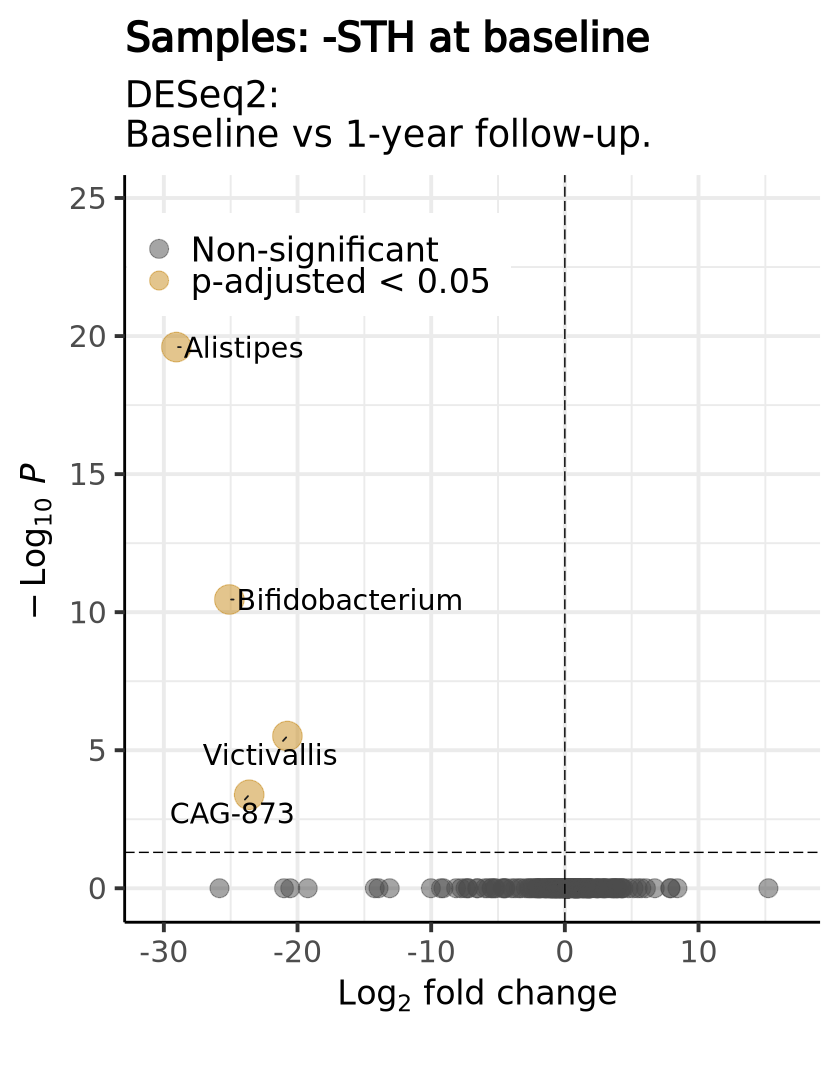

In [27]:
# volcano plot
width = 7
height = 9
options(repr.plot.width=width, repr.plot.height=height)

pCutoff <- 50e-3 # 0.05
FCcutoff <- 1

p <- EnhancedVolcano(dds_res,
                lab = dds_res[['lab']], 
    x = 'log2FoldChange',
    y = 'padj', 
    pCutoff = pCutoff,
    FCcutoff = 0,
    labSize = 6,
    legendPosition = c(0.28, 0.88),
    legendLabSize = 20, 
    legendLabels = c("", "Non-significant", "",  "p-adjusted < 0.05"),
    pointSize=dds_res$point_size, 
    drawConnectors = TRUE, 
    lengthConnectors = unit(0.2, "npc"),
    arrowheads = FALSE,
    colAlpha=0.5,
    col = c("grey30", "grey30", "royalblue", "#c88c1c" ),
    title = bquote("Samples: -STH at baseline"),
    subtitle = "DESeq2:\nBaseline vs 1-year follow-up.",
    titleLabSize = 24,
    subtitleLabSize = 22,
    caption = "") + 
    theme(axis.title=element_text(size=20))
print(p)

k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure5', 'DESeq2.noSTH.volcano_plot.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)

#### Boxplots

In [28]:
# reload and re-prepare the phylsoeq object as it was done baseline
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')
# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))
tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]
ps_relative <- prune_samples(row.names(metadata_deseq2), ps)
# normalize abundances
ps_relative <- transform_sample_counts(ps_relative, function(x){x / sum(x)})
# eliminate taxa that are harnoured only by one sample
otu_data <- as.data.frame(otu_table(ps_relative))

In [29]:
# subset all the significant taxa according to DESeq2
otu_data_boxplot <- otu_data[, dds_res[dds_res$padj <= 0.05, ]$lab]
otu_data_boxplot$grouping <- factor(metadata_deseq2[row.names(otu_data_boxplot), 'collection_timepoint'],
                                    levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_deseq2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)

Using grouping, host_subject_id as id variables



In [30]:
# prepare the p-values table
test_pvalues <- dds_res[dds_res$padj <= 0.05, ]
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"
# test_pvalues$y.position <- c(0.0073, 0.105,  0.0105)
test_pvalues$plabel <- formatC(test_pvalues$padj, format='f', digits=4)
test_pvalues[test_pvalues$plabel != '0.0000', ]$plabel <- paste0('= ', 
                                test_pvalues[test_pvalues$plabel != '0.0000', ]$plabel)
test_pvalues[test_pvalues$plabel == '0.0000', ]$plabel <- '< 10-4'
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1

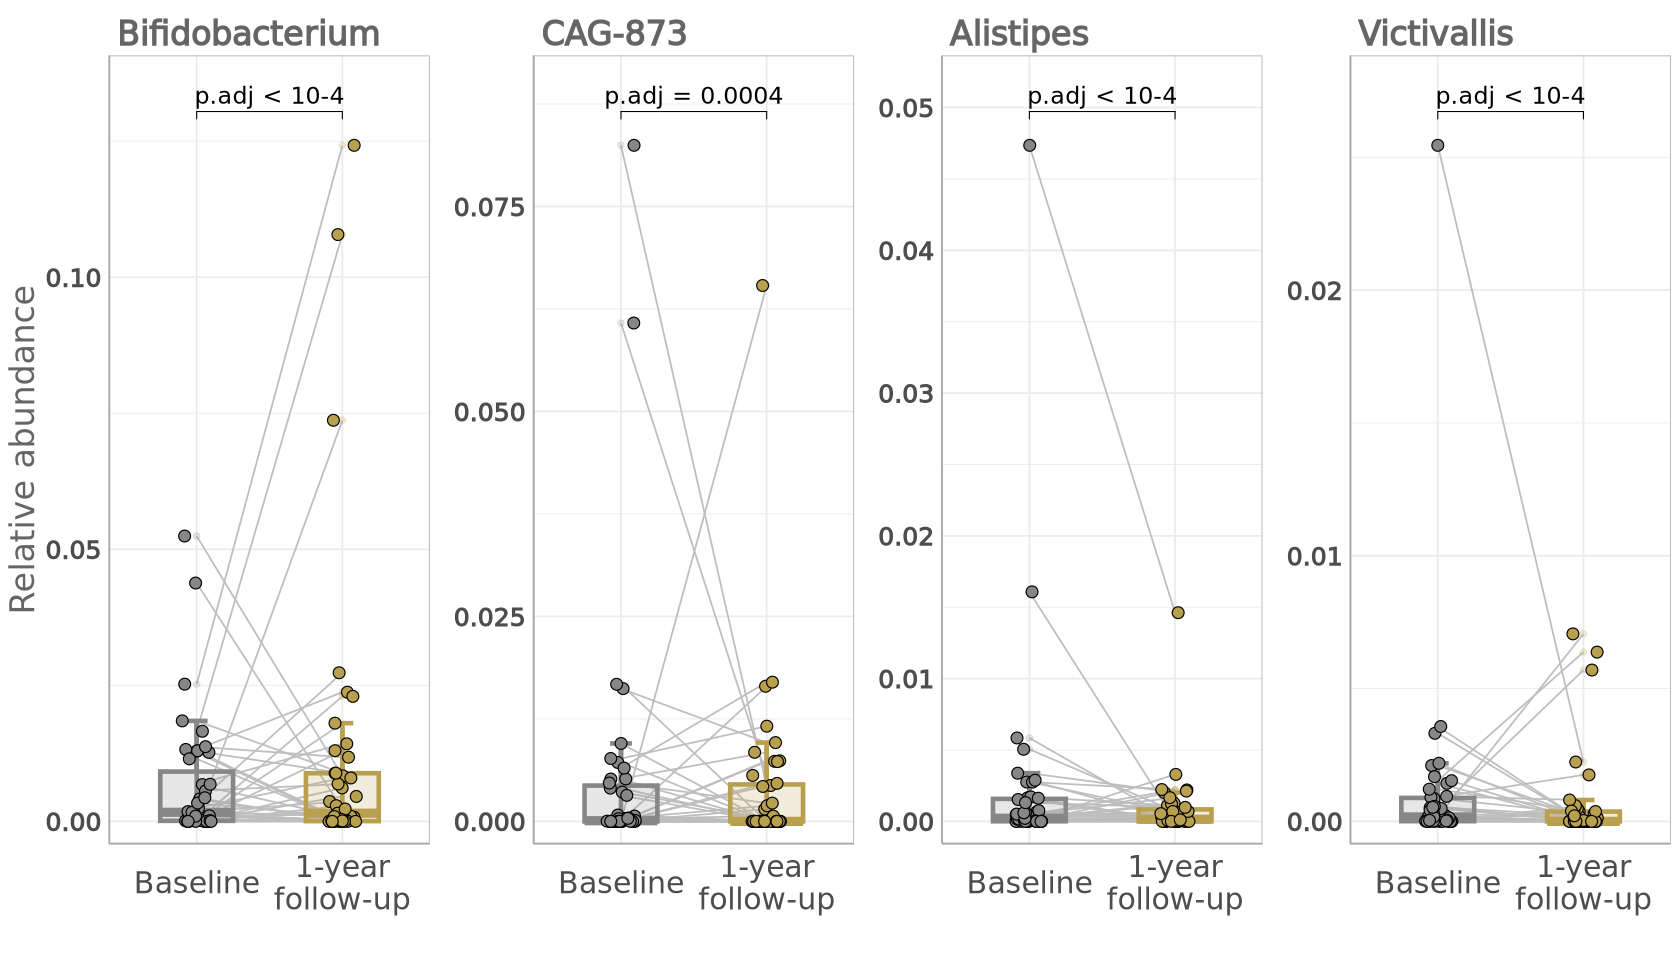

In [31]:
width = 14
height = 8
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
      geom_line(aes(x = grouping, y=value, group = host_subject_id), color = "gray", linewidth = 0.5,) +
      stat_boxplot(aes(x=grouping, y=value, color = grouping), geom = "errorbar", width = 0.15, lwd=1.3) +
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping), alpha=0.2, lwd=1.3, width=0.5) +
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping), size=3, width=0.1, shape=21, color='black')  + 
      stat_pvalue_manual(data=test_pvalues, label='p.adj {plabel}', label.size=5, tip.length=0.01) +
      facet_wrap(~variable, scales = "free_y", ncol=4) + 
      scale_fill_manual(values = c('#878787', '#b9a04f')) +
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
      labs(x = "", y = "Relative abundance") +
      scale_y_continuous(expand = expansion(mult = 0.03)) +
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
#       theme_bw() +
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=18, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none", 
           ) 
k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure5', 'DESeq2.noSTH.boxplots.all.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

## Positive STH at the baseline

### Load data

In [32]:
# load genus level agglomerated data
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')

# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))

# tax_data['names'] <- paste(tax_data[, 'Family'], tax_data[, 'Genus'], sep=';')
tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]

In [33]:
# create a new metadata columns which for each sample
# would contain the information about STH status at the baseline
#     baseline_noSTH: a sample was collected at the baseline timepoint and was STH-negative at the baseline
#     followup_noSTH: a sample was collected at the follow-up timepoint and was STH-negative at the baseline
#     baseline_STH: a sample was collected at the baseline timepoint and was STH-positive at the baseline
#     followup_STH: a sample was collected at the follow-up timepoint and was STH-positive at the baseline
STHStatus <- rep('baseline_noSTH', dim(sample_data(ps))[1])
STHStatus_baseline_all <- ((sample_data(ps)[['collection_timepoint']] == 'baseline') & 
                       (sample_data(ps)[['subject_eggcountAnySTHs_baseline']] > 0))
STHStatus[STHStatus_baseline_all] <- 'baseline_STH'
STHStatus_followup <- (sample_data(ps)[['collection_timepoint']] == 'follow-up')
STHStatus[STHStatus_followup] <- 'followup_noSTH'
STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                    (sample_data(ps)[['subject_eggcountAnySTHs_baseline']] > 0))
STHStatus[STHStatus_followup] <- 'followup_STH'
sample_data(ps)['STHStatus_baseline'] <- STHStatus

### Deseq2

In [34]:
# select only paired samples and those who were STH-positive at the baseline
otu_data <- data.frame(otu_table(ps))
metadata <- data.frame(sample_data(ps))
group_baseline <- metadata[((metadata[['collection_timepoint']] == 'baseline') &
                (metadata[['STHStatus_baseline']] == 'baseline_STH')), ]
group_followup <- metadata[((metadata[['collection_timepoint']] == 'follow-up') &
                (metadata[['STHStatus_baseline']] == 'followup_STH')), ]
row.names(group_baseline) <- group_baseline[['host_subject_id']]
row.names(group_followup) <- group_followup[['host_subject_id']]
group_baseline <- group_baseline[row.names(group_followup), ]
row.names(group_baseline) <- group_baseline[['sample_alias']]
row.names(group_followup) <- group_followup[['sample_alias']]
metadata_deseq2 <- rbind(group_baseline, group_followup)
otu_data_deseq2 <- otu_data[row.names(metadata_deseq2), ]

In [35]:
# check the number of samples
dim(otu_data_deseq2)[1]

[1] 48

In [36]:
# check that we do not have any unpaired samples left
# the result should be 0
sum(table(metadata_deseq2['host_subject_id']) != 2)

[1] 0

In [37]:
# check that samples are in correct order for the paired test
# the result should be 0
sum((metadata_deseq2[metadata_deseq2$collection_timepoint == 'baseline', 'host_subject_id'] ==
     metadata_deseq2[metadata_deseq2$collection_timepoint == 'follow-up', 'host_subject_id']) != TRUE)

[1] 0

In [38]:
# subset the phyloseq object with the selected samples
ps <- prune_samples(row.names(metadata_deseq2), ps)
ps
sample_data(ps)['host_subject_id'] <- factor(sample_data(ps)[['host_subject_id']])
sample_data(ps)['collection_timepoint'] <- factor(sample_data(ps)[['collection_timepoint']], levels=c('follow-up', 'baseline'))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 397 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 397 taxa by 7 taxonomic ranks ]

In [39]:
# convert phyloseq to DESeq2 object
dds <- phyloseq_to_deseq2(ps, ~ collection_timepoint + host_subject_id)
# perform DESeq2 analysis
dds <- DESeq(dds)
dds_res <- data.frame(results(dds))
dds_res_summary <- dds_res
dds_res['lab'] <- row.names(dds_res)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R.

In [40]:
p_values_summary_table_3 <- cbind(data.frame(tax_table(ps))[row.names(dds_res_summary), 
                                      c('Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus')], 
                        dds_res_summary)

### DESeq2 Plots

In [41]:
dds_res <- dds_res[!is.na(dds_res$padj), ]
dds_res$point_size <- 5
dds_res[dds_res$padj <= 0.05, 'point_size'] <- 8
dds_res[dds_res$padj <= 0.05, ]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,lab,point_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Succinivibrio,23510.87521,-14.185156,3.356112,-4.226663,2.371827e-05,1.223863e-03,Succinivibrio,8
Rikenellaceae_RC9_gut_group,2176.79151,22.144688,2.642921,8.378870,5.343821e-17,1.378706e-14,Rikenellaceae_RC9_gut_group,8
Lachnospiraceae_NK3A20_group,258.61188,20.474869,4.502157,4.547791,5.421200e-06,3.496674e-04,Lachnospiraceae_NK3A20_group,8
Prevotellaceae_NK3B31_group,243.17998,18.833277,3.319251,5.673953,1.395394e-08,1.800058e-06,Prevotellaceae_NK3B31_group,8
Mogibacterium,67.28882,18.258482,3.989671,4.576437,4.729609e-06,3.496674e-04,Mogibacterium,8
GCA-900066225,124.91177,7.885533,1.944566,4.055164,5.009919e-05,2.154265e-03,GCA-900066225,8


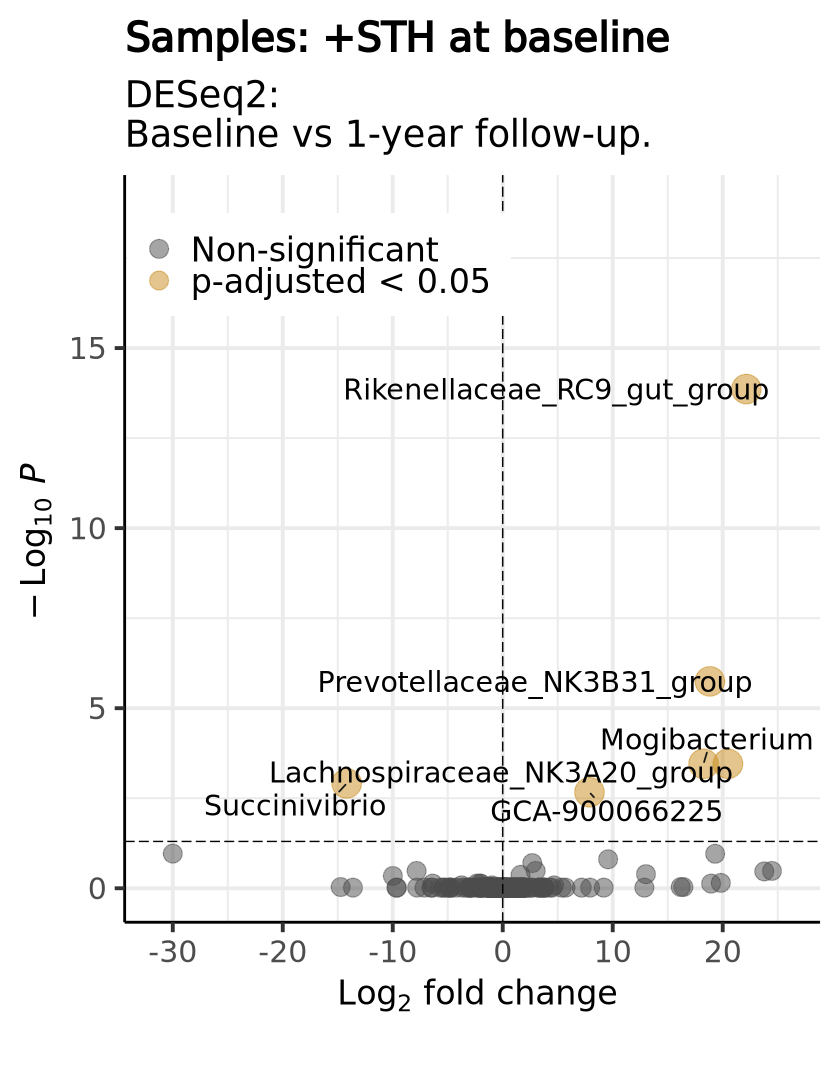

In [42]:
width = 7
height = 9
options(repr.plot.width=width, repr.plot.height=height)

pCutoff <- 50e-3 # 0.05
FCcutoff <- 1

p <- EnhancedVolcano(dds_res,
                lab = dds_res[['lab']], 
    x = 'log2FoldChange',
    y = 'padj', 
    pCutoff = pCutoff,
    FCcutoff = 0,
    labSize = 6,
    legendPosition = c(0.28, 0.88),
    legendLabSize = 20, 
    legendLabels = c("", "Non-significant", "", "p-adjusted < 0.05"),
    pointSize=dds_res$point_size, 
    drawConnectors = TRUE, 
    lengthConnectors = unit(0.2, "npc"),
    arrowheads = FALSE,
    colAlpha=0.5,
    col = c("grey30", "grey30", "royalblue", "#c88c1c" ),
    title = bquote("Samples: +STH at baseline"), 
    subtitle = "DESeq2:\nBaseline vs 1-year follow-up.",
    titleLabSize = 24,
    subtitleLabSize = 22,
    caption = "") + 
    theme(axis.title=element_text(size=20))
print(p)

k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure5', 'DESeq2.STH.volcano_plot.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)

#### Boxplots

In [43]:
ps <- readRDS('../../data/phyloseq/nohost_genus/phyloseq.rds')
# rename otu_data table columns with Bacteria names
tax_data <- data.frame(tax_table(ps))
tax_data['names'] <- tax_data[, 'Genus']
taxa_names(ps) <- tax_data[['names']]
ps_relative <- prune_samples(row.names(metadata_deseq2), ps)
# normalize abundances
ps_relative <- transform_sample_counts(ps_relative, function(x){x / sum(x)})
# eliminate taxa that are harnoured only by one sample
otu_data <- as.data.frame(otu_table(ps_relative))

In [44]:
# select only significant taxa according to deseq2
otu_data_boxplot <- otu_data[, dds_res[dds_res$padj <= 0.05, ]$lab]
otu_data_boxplot$grouping <- factor(metadata_deseq2[row.names(otu_data_boxplot), 'collection_timepoint'],
                                    levels=c('baseline', 'follow-up'))
levels(otu_data_boxplot$grouping) <- c("Baseline", "1-year\nfollow-up")
otu_data_boxplot$host_subject_id <- metadata_deseq2$host_subject_id
otu_data_boxplot <- melt(otu_data_boxplot)

Using grouping, host_subject_id as id variables



In [47]:
# prepare p-values table
test_pvalues <- dds_res[dds_res$padj <= 0.05, ]
test_pvalues$group1 <- "Baseline"
test_pvalues$group2 <- "1-year\nfollow-up"

test_pvalues$plabel <- formatC(test_pvalues$padj, format='f', digits=4)
test_pvalues[test_pvalues$plabel != '0.0000', ]$plabel <- paste0('= ', 
                                test_pvalues[test_pvalues$plabel != '0.0000', ]$plabel)
test_pvalues[test_pvalues$plabel == '0.0000', ]$plabel <- '< 10-4'
test_pvalues$variable <- factor(test_pvalues$lab, levels=test_pvalues$lab)

otu_data_max <- filter(otu_data_boxplot, value==max(value), .by=variable)
max_y <- data.frame(value = otu_data_max$value*1.05, row.names=otu_data_max$variable)
test_pvalues$y.position <- max_y[test_pvalues$lab, 'value']
otu_data_max$value <- otu_data_max$value*1.1


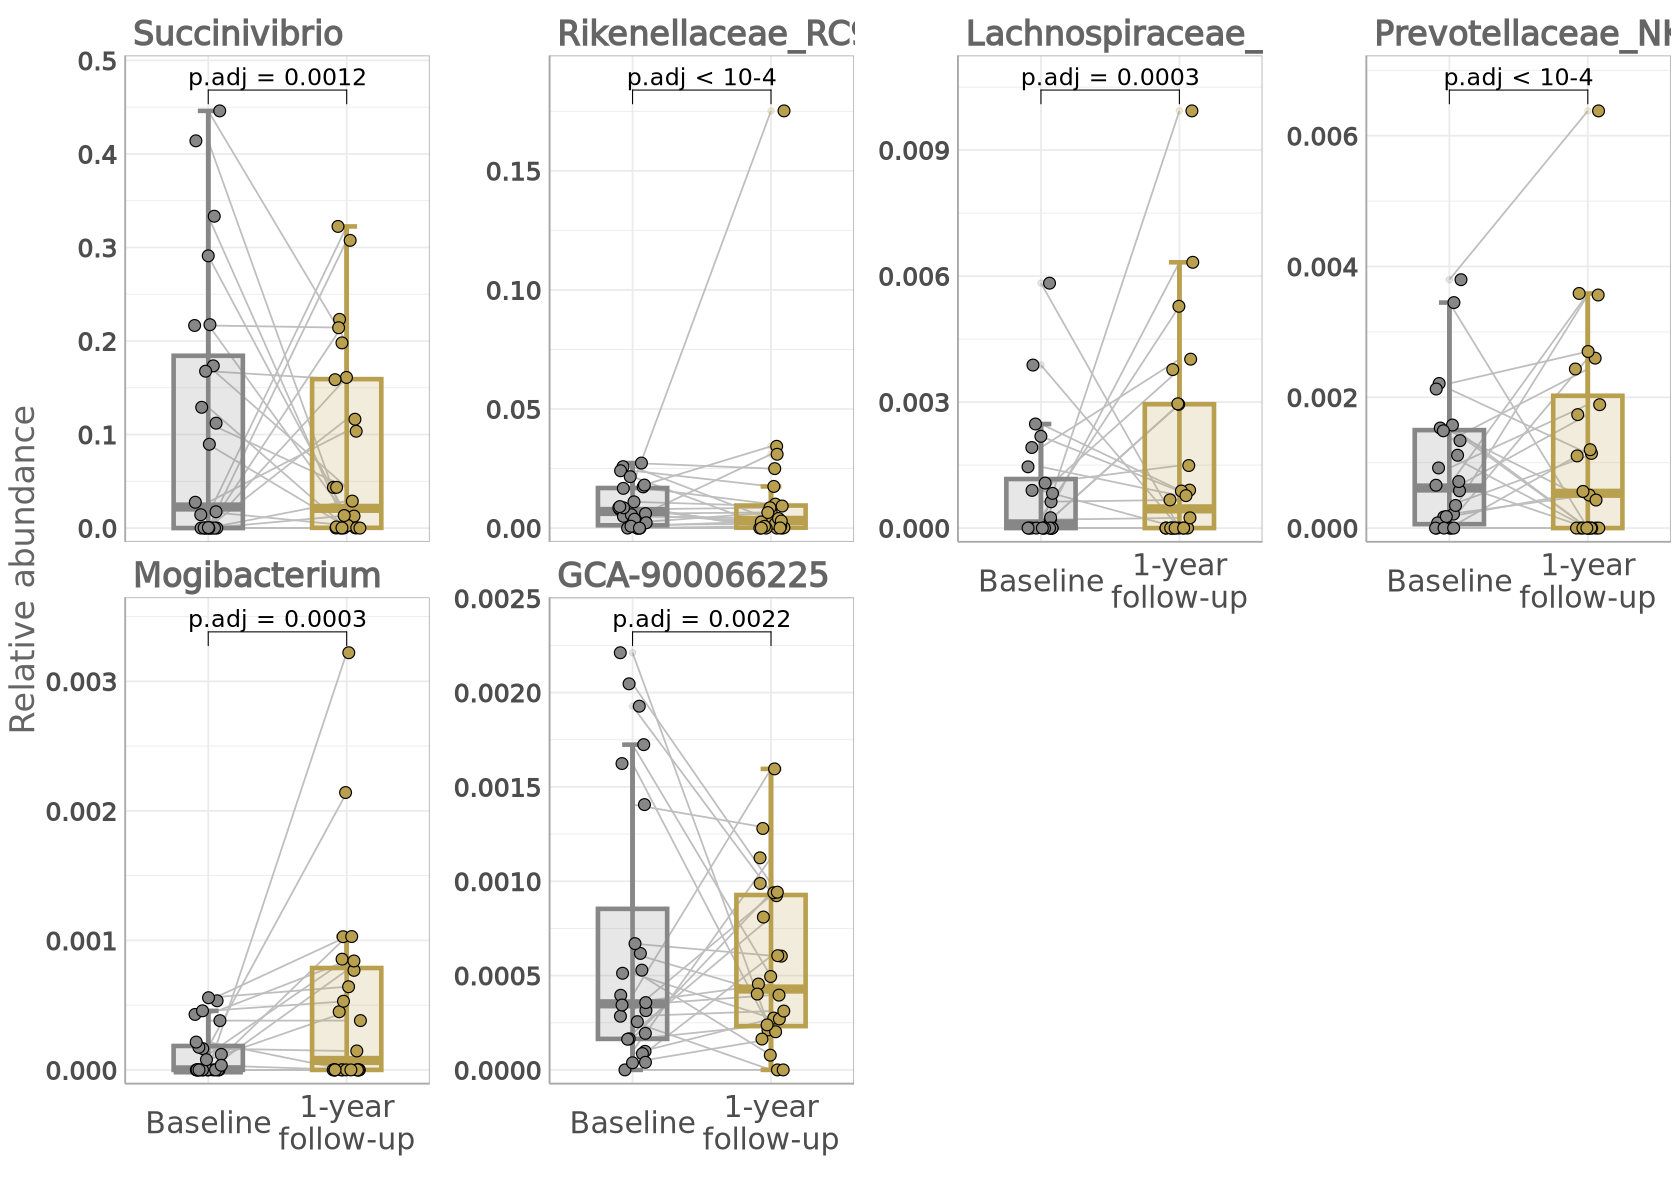

In [48]:
width = 14
height = 10
options(repr.plot.width=width, repr.plot.height=height)
comparisons <- list(c("Baseline", "1-year\nfollow-up"))

p <- ggplot(otu_data_boxplot) + 
      geom_line(aes(x = grouping, y=value, group = host_subject_id), color = "gray", size = 0.5,) +
      stat_boxplot(aes(x=grouping, y=value, color = grouping), geom = "errorbar", width = 0.15, lwd=1.3) +
      geom_boxplot(aes(x=grouping, y=value, color = grouping, fill=grouping), alpha=0.2, lwd=1.3, width=0.5) +
      geom_jitter(aes(x=grouping, y=value, color = grouping, fill=grouping), size=3, width=0.1, shape=21, color='black')  + 
      stat_pvalue_manual(data=test_pvalues, label='p.adj {plabel}', label.size=5, tip.length=0.03) +
      facet_wrap(~variable, scales = "free_y", ncol=4) + 
      scale_fill_manual(values = c('#878787', '#b9a04f')) + 
      scale_colour_manual(values = c('#878787', '#b9a04f')) +
      labs(x = "", y = "Relative abundance") +
      scale_y_continuous(expand = expansion(mult = 0.03)) +
      geom_blank(data = otu_data_max, aes(x = grouping, y=value, group = host_subject_id)) +
      theme_minimal() +
      theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="bold"), 
            plot.title=element_text(size=24, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 20, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=18, angle=0, face='plain', vjust = 0.5, hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 25, face="bold"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(1, "lines"),
            legend.position="none", 
           ) 

k = 0.3
ggsave(file=file.path('../../results/figures', 'supplementary_figure5', 'DESeq2.STH.boxplots.all.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

# Save xlsx

In [49]:
p_values_summary_table <- list(All = p_values_summary_table_1, 
                               STH_negative = p_values_summary_table_2, 
                               STH_positive= p_values_summary_table_3)
write_xlsx(p_values_summary_table, file.path('../../results/tables', 'Table S3.DESeq2.xlsx'))